The Restricted Boltzmann Machine (RBM) is a pairwise Markov random field with a bipartite graph structure consisting of observed variables $v_i$, $i=1,...,V$, and hidden variables $h_j$, $j=1,...,H$. Here I consider the most common type of RMB with binary units (i.e., discrete random variables taking values in $\{0, 1\}$). The joint distribution is
$$
p(h, v) = \frac{1}{Z} \exp \{ b^T v + c^T h + v^T W h \}
$$
Clearly this specifies an exponential family distribution with sufficient statistics functions $v_i$, $h_j$, and $v_i h_j$, and corresponding natural parameters $b_i$, $c_j$, $W_{ij}$, for $i=1,...,V$ and $j=1,...,H$.

See http://www.deeplearningbook.org/contents/generative_models.html for a more detailed description of RBMs, including equations like conditional distributions $p_\theta(h|v)$ used in code. Also see Joshua Bengio's [Learning Deep Architectures for AI](http://www.iro.umontreal.ca/~bengioy/papers/ftml.pdf) for a comprehensive treatment.

I use $\tilde p$ to denote the unnormalized probability measure associated with a model, i.e., $p(x) = \tilde p(x) / Z$ where $Z$ is the partition function. In the case of an exponential family model, we can use natural parameterization to write $\tilde p(x) = \exp \{ \langle \theta, \phi(x) \rangle \}$. The deep learning community seems to prefer using the energy function from physics: $E(x) = - \log \tilde p(x)$, so $p(x) = e^{-E(x)}/Z$. In an exponential family, we then have $E(x) = - \langle \theta, \phi(x) \rangle$; specifically for the RBM considered here, $E(h, v) = - b^T v - c^T h - v^T W h$.

Suppose we observe $N$ samples $h^{(1)}, ...,h^{(N)}$, and want to learn a model of $p(h)$. 
The (average) incomplete log-likelihood of $N$ samples is
$$
\ell(\theta) = \frac{1}{N} \sum_n \log p_\theta(v^{(n)}) = \frac{1}{N} \sum_n \log \tilde p_\theta(v^{(n)}) - \log Z
$$
which takes the form of a difference between log partition functions. 

The gradient is then
$$
\nabla_\theta \ell(\theta) = \frac{1}{N} \sum_n \nabla_\theta \log \tilde p_\theta(v^{(n)}) - \nabla_\theta \log Z
$$

For a generic model $p(x)$, it's not hard to show $\nabla_\theta \log Z = \mathbb{E}_{p_\theta(x)}[\nabla_\theta \log \tilde p(x)]$.
For exponential families, we further have $\nabla_\theta \log \tilde p(x) = \phi(x)$ so $\nabla_\theta \log Z=\mathbb{E}_{p_\theta(x)}[\phi(x)]$. We can thus further simplify the gradient of $\ell$:
$$
\frac{\partial \ell }{\partial \theta_i} = \frac{1}{N} \sum_n \mathbb{E}_{p_\theta(h|v^{(n)})}[\phi_i] - \mathbb{E}_{p_\theta(h, v)}[\phi_i]
$$

This shows that in general, to compute the gradient of the incomplete log-likelihood, we need to run inference $N+1$ times; the first $N$ times with evidence to compute the first term for every data instance, and once in the joint model $p_\theta(h, v)$. Recall each conditional inference $p_\theta(h|v^{(n)})$ occurs in the reduced Markov network over $h$ only, which is easier than in the joint model $p_\theta(h, v)$. Indeed, in the case of RBM, the bipartite graph structure allows computing $p_\theta(h|v)$ in closed-form in linear time (the reduced Markov network underlying $p_\theta(h|v)$ simply consists of disconnected nodes $h_j, j=1,...,H$); the same applies to $p(v|h)$ by symmetry.

We have

\begin{align*}
\frac{\partial \ell }{\partial b_i} &= \frac{1}{N} \sum_n \mathbb{E}_{p_\theta(h|v^{(n)})}[v_i^{(n)}] - \mathbb{E}_{p_\theta(h, v)}[v_i] = \frac{1}{N} \sum_n v_i^{(n)} -p_\theta(v_i=1) \\
\frac{\partial \ell }{\partial c_j} &= \frac{1}{N} \sum_n \mathbb{E}_{p_\theta(h|v^{(n)})}[h_j] - \mathbb{E}_{p_\theta(h, v)}[h_j] = \frac{1}{N} \sum_n p(h_j| v^{(n)}) -p_\theta(h_j=1) \\
\frac{\partial \ell }{\partial W_{ij}} &= \frac{1}{N} \sum_n \mathbb{E}_{p_\theta(h|v^{(n)})}[v_i h_j] - \mathbb{E}_{p_\theta(h, v)}[v_i h_j] = \frac{1}{N} \sum_n v_i^{(n)} p_\theta(h_j=1| v^{(n)}) -p_\theta(v_i=1, h_j=1)
\end{align*}

Unfortunately however, the second terms (expectations w.r.t. $p(h,v)$) in the gradient are generally not tractable to compute exactly, due to the need to compute $Z$. One idea is to use Monte Carlo methods to approximate them, prominently featured in the Contrastive Divergence algorithm. Even though (block) Gibbs sampling is efficient in RBM, running it to convergence every gradient iteration is still expensive. Therefore, in $k$-step Contrastive Divergence (CD-$k$), we simply run MCMC $k$ steps, starting from some observed sample. This is Algorithm 18.2 in the Deep Learning book: for every gradient iteration, we sample a minibatch $h^{(1)}, ...,h^{(N)}$ from data, and run $N$ MCMC chains for $k$ steps independently, with the $n$th chain initialized at the $n$th sample $h^{(n)}$. 

Below I demonstrate learning an RBM over MNIST images by maximizing the (incomplete) log-likelihood with SGD, using $k$-step Constrastive Divergence for gradient approximation. Note [`np.random.binomial(n=1, p=probs)`]( https://stackoverflow.com/questions/36398445/numpy-draw-a-few-bernoulli-distributions-at-once) can be used to efficiently draw multiple Bernoulli samples at once.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.special import expit
import numpy as np



def p_h_given_v(v, c, W):
    """
    Compute p(h_j=1|v), for a vector h
    :param c:
    :param v:
    :param W:
    :return:
    """
    return expit(c + np.dot(v, W))


def p_v_given_h(h, b, W):
    """
    Compute p(v_i=1|h), for a vector v
    :param b:
    :param h:
    :param W:
    :return:
    """
    return expit(b + np.dot(W, h))


def sample_h_given_v(c, v, W):
    """
    Sample h from p(h|v)
    :param c:
    :param v:
    :param W:
    :return:
    """
    return np.random.binomial(n=1, p=p_h_given_v(v, c, W))


def sample_v_given_h(b, h, W):
    """
    Sample v from p(v|h)
    :param b:
    :param h:
    :param W:
    :return:
    """
    return np.random.binomial(n=1, p=p_v_given_h(h, b, W))


def gibbs_k(v0, k, b, c, W):
    """
    Run Gibbs sampling for k iterations; only the last joint sample (v, h) is returned for CD-k.
    :param v0: initial observed variables
    :param k: gibbs steps; must > 0
    :param b:
    :param h:
    :param W:
    :return:
    """
    v = v0
    for t in range(k):
        h = sample_h_given_v(c, v, W)
        v = sample_v_given_h(b, h, W)
    return v, h


def reconstruct(v0, b, c, W):
    """
    Given v0, sample a h and use it to reconstruct a v = E[h|v] = p(h|v)
    :param v0:
    :param k:
    :param b:
    :param c:
    :param W:
    :return:
    """
    h = sample_h_given_v(c, v0, W)
    return p_v_given_h(h, b, W)


def suff_stats(data, c, W):
    """
    Compute the positive-phase sufficient stats (first term of the log-likelihood gradient) when given a
    batch of observations.
    :param data:
    :param b:
    :param c:
    :param W:
    :return:
    """
    N = len(data)
    H = c.size
    v_s = np.mean(data, axis=0)
    p_h_s = np.empty([N, H])
    for n, d in enumerate(data):
        p_h_s[n] = p_h_given_v(d, c, W)

    h_s = np.mean(p_h_s, axis=0)
    W_s = np.dot(data.T, p_h_s) / N  # V by N times N by H
    return v_s, h_s, W_s


def init_params(V, H, data=None):
    """
    Initialize params of the binary RBM; advice from http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf
    :param V: dimension of observed vars
    :param H: dimension of hidden vars
    :return: (b, c, W)
    """
    if data is not None:
        p_marg = np.mean(data, axis=0)  # marginal distributions of each \hat p(x_i)
        p_marg[p_marg < 0.001] = 0.001  # avoid zeros
        b = np.log(p_marg) - np.log(1 - p_marg)
    else:
        b = np.zeros(V)
    c = np.zeros(H)
    W = np.random.normal(scale=0.01, size=[V, H])
    return b, c, W


def load_data(n_samples):
    """
    Get a n_samples by V array of binary samples
    :param n_samples:
    :return:
    """
    mnist = np.load('../data/mnist.npz')
    data = mnist['x_train']
    data = data[:n_samples]
    data = data.reshape([n_samples, 28 * 28])

    # binarize
    data[data < 128] = 0
    data[data >= 128] = 1
    return data


In [2]:
n_samples = 10000   # use the first 10000 images of training data
data = load_data(n_samples)
n_samples, V = data.shape
assert V == 784

H = 500    # number of hidden units

In [3]:
b, c, W = init_params(V, H, data)

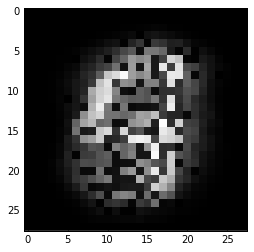

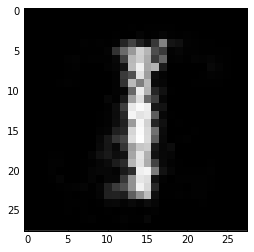

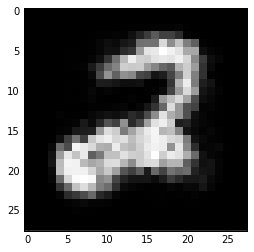

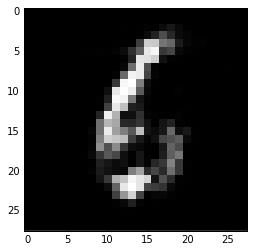

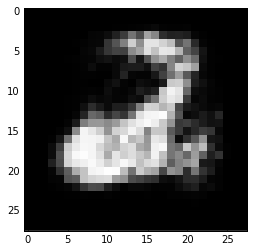

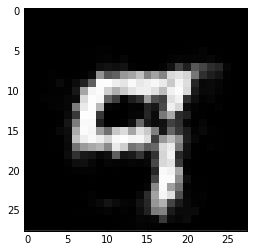

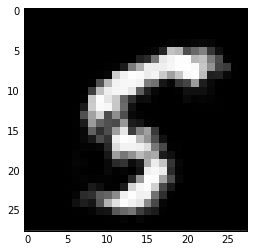

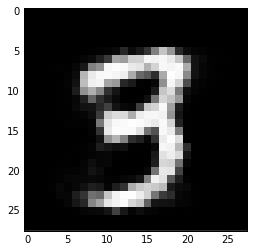

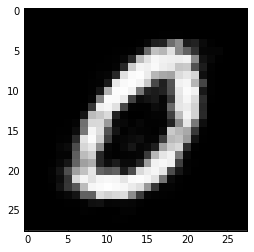

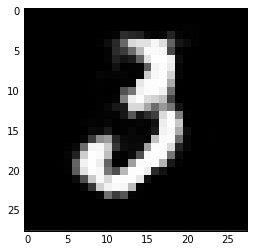

In [4]:
# train with CD-k
T = 20000  # num training iterations
N = 1  # batch size
k = 2  # num of Gibbs sampling steps
lr = 0.01

for t in range(T):
    data_ids = np.random.choice(n_samples, size=N)
    batch = data[data_ids]
    db, dc, dW = suff_stats(batch, c, W)   # 1st gradient term, positive phase done exactly
    # Gibbs sampling to approximate the 2nd gradient term (negative phase)
    # Could be implemented more efficiently, by Gibbs sampling for the entire batch without the outer loop
    # Containers for "negative particles"
    vs = np.empty([N, V])
    hs = np.empty([N, H])
    for n, d in enumerate(batch):
        v, h = gibbs_k(d, k, b, c, W)
        vs[n] = v
        hs[n] = h
    # model expected suff stats; 2nd gradient term approximated
    db -= np.mean(vs, axis=0)
    dc -= np.mean(hs, axis=0)
    dW -= np.dot(vs.T, hs) / N
    
    b += lr * db
    c += lr * dc
    W += lr * dW
    
    if t % 2000 == 0:
        plt.figure()
        # visualize a Gibbs sample
#         vis = vs[0]
        vis = p_v_given_h(hs[0], b, W)
        plt.imshow(vis.reshape([28, 28]), cmap='gray', interpolation='none')
        
        plt.show()

In [5]:
W_abs_max = np.abs(W).max()
print(W.min(), W.max())

-1.72758295797 1.84827739147


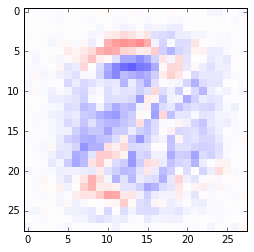

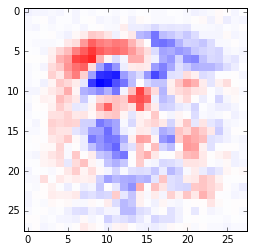

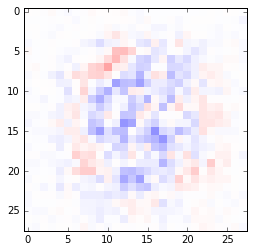

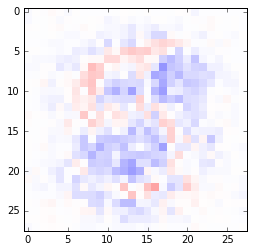

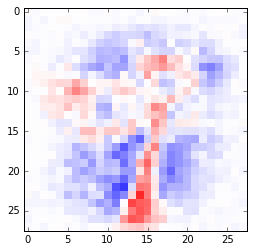

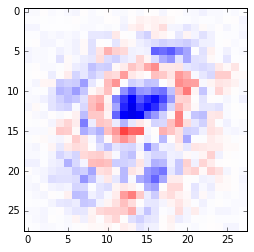

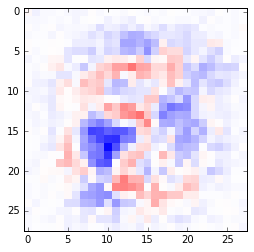

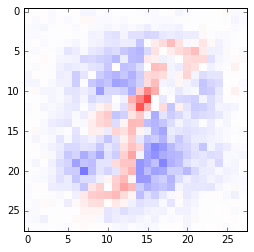

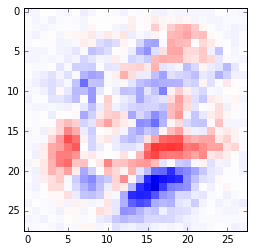

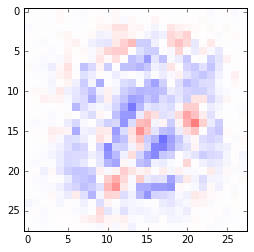

In [6]:
# visualize some learned weights (W)
for h in range(10):
    plt.figure()
    plt.imshow(W[:, h].reshape([28, 28]), vmin=-W_abs_max, vmax=W_abs_max, cmap='seismic', interpolation='none')